降水量と流量が線形関係にあるかどうかを調査する。

流量は1ヵ月に1回しか測定がない。降水量は毎時情報がある。ともあれ、なんか関係は得られるだろう。

~~24時間のインパルス応答を調査する。~~ 144時間(6日間)のインパルス応答を調査する。

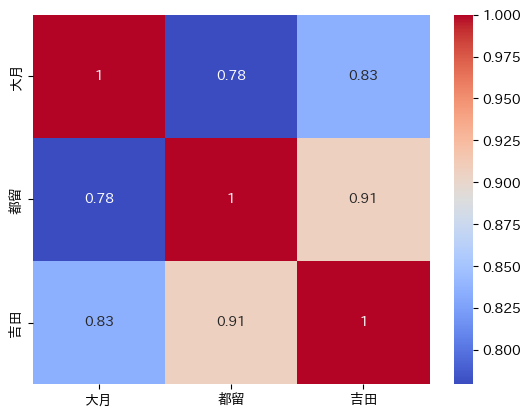

In [58]:
# 大月 open-meteo-35.61N139.05E350m.csv
# 都留 open-meteo-35.54N138.99E506m.csv
# 吉田 open-meteo-35.47N138.92E813m.csv

# これらの地点は近接しているので、降水量はかなり近いはず。確認する。

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import japanize_matplotlib

# 先頭3行を無視
大月 = pd.read_csv("open-meteo-35.61N139.05E350m.csv", skiprows=3, parse_dates=[0])
都留 = pd.read_csv("open-meteo-35.54N138.99E506m.csv", skiprows=3, parse_dates=[0])
吉田 = pd.read_csv("open-meteo-35.47N138.92E813m.csv", skiprows=3, parse_dates=[0])

# Time zoneを設定しておく。
大月.time = 大月.time.dt.tz_localize("Asia/Tokyo")
都留.time = 都留.time.dt.tz_localize("Asia/Tokyo")
吉田.time = 吉田.time.dt.tz_localize("Asia/Tokyo")

# くっつける
merged = pd.concat(
    [
        大月.rename({"rain (mm)": "大月"}, axis="columns")["大月"],
        都留.rename({"rain (mm)": "都留"}, axis="columns")["都留"],
        吉田.rename({"rain (mm)": "吉田"}, axis="columns")["吉田"],
    ],
    axis=1,
)

# 相関係数のheatmap
sns.heatmap(merged.corr(), annot=True, cmap="coolwarm")
plt.show()

かなり相関があるので、どの地点で代表させてもいいだろう。

流量推定時刻の~~23時間前以降の24時間分~~143時間前以降の144時間分の降水量で、流量を線形予測する。

これで得られる比例係数がインパルス応答。

In [137]:
昭和橋 = pd.read_csv("昭和橋.flow.csv", dtype={0: str, 1: str}, parse_dates=[1])

# 分を0にした、切りのよい時刻を準備
昭和橋["time"] = 昭和橋.datetime.dt.floor("h")
昭和橋.head()

,unixtime,datetime,value,time
0,956109900,2000-04-19 11:05:00+09:00,1.02,2000-04-19 11:00:00+09:00
1,957924300,2000-05-10 11:05:00+09:00,0.97,2000-05-10 11:00:00+09:00
2,960343500,2000-06-07 11:05:00+09:00,0.57,2000-06-07 11:00:00+09:00
3,962762460,2000-07-05 11:01:00+09:00,1.34,2000-07-05 11:00:00+09:00
4,965181840,2000-08-02 11:04:00+09:00,5.18,2000-08-02 11:00:00+09:00


過去144時間分のデータを準備する。

In [115]:
def delayed_data(rain_data, lookback=30):
    L = rain_data.shape[0]
    # 時間ずらしデータ。最初が一番古いデータになるはず。
    X_ = np.zeros([L, lookback])
    for i in range(lookback):
        X_[i:, lookback - i - 1] = rain_data["rain (mm)"][: L - i]

    # 0埋めされてしまった最初の(lookback)個は捨てる。
    tick = rain_data["time"][lookback - 1 :]
    return tick, X_[lookback - 1 :]


lookback = 144

tick, rains = delayed_data(大月, lookback=lookback)
# 最初が最新になるように反転(インパルス応答の目盛りにあわせる)
rains = rains[:, ::-1]
tick.head(), rains[:5]

(143   2000-04-06 23:00:00+09:00
 144   2000-04-07 00:00:00+09:00
 145   2000-04-07 01:00:00+09:00
 146   2000-04-07 02:00:00+09:00
 147   2000-04-07 03:00:00+09:00
 Name: time, dtype: datetime64[ns, Asia/Tokyo],
 array([[0. , 0. , 0. , 0. , 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1, 0.1, 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.1,
         0.3, 0.4, 0.6, 0.6, 0.7, 0.8, 0.8, 0.6, 0.7, 1.2, 2.7, 3.1, 1.9,
         1.1, 0.4, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0.1, 0.1, 0.1, 0.1, 0.2, 0.1, 0. , 0.1,
         0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. 

In [152]:
X = []
y = []
for i, t in enumerate(昭和橋.time):
    rows = tick == t
    row = rains[rows]
    if row.shape[0] == 1:
        X.append(row)
        y.append(昭和橋[昭和橋.time == t]["value"].to_numpy())

X = np.array(X).reshape(-1, lookback)
y = np.array(y).flatten()
X[:5], y[:5]

(array([[1.1, 1. , 0.8, 0.5, 0.2, 0.3, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0.2, 0. , 0.1, 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0.1, 0. , 0. , 0.1, 0.1, 0.1, 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0.3, 0.1, 0. ,
         0. , 0. , 0. , 0.1, 0.2, 0.3, 0.2, 0.4, 0.6, 0.8, 0.8, 0.7, 0.6,
         0.5, 0.3, 0.2, 0.2, 0.2, 0.3, 0.5, 0.5, 0.8, 1.1, 1. , 1.1, 1.2,
         1. , 0.6, 0.2, 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0.3, 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. ],
        [0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. , 0. ,
         0. , 0. , 0. ,

In [139]:
X, y, X.shape

(array([[1.1, 1. , 0.8, ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ...,
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ]]),
 array([ 1.02  ,  0.97  ,  0.57  ,  1.34  ,  5.18  ,  1.75  ,  5.76  ,
         3.25  ,  1.45  ,  6.23  ,  4.64  ,  1.69  ,  1.26  ,  1.23  ,
         1.99  ,  1.67  ,  1.54  ,  2.13  ,  8.86  ,  5.33  ,  6.99  ,
         1.76  ,  1.86  ,  1.93  ,  1.55  ,  0.96  ,  1.22  ,  1.41  ,
         1.22  ,  1.42  ,  9.61  ,  1.88  ,  4.39  ,  1.51  ,  1.61  ,
         1.59  ,  1.543 ,  1.725 ,  4.632 ,  4.485 , 10.981 ,  7.101 ,
         6.162 ,  1.256 ,  3.788 ,  1.961 ,  1.663 ,  3.968 ,  1.49  ,
         0.86  ,  0.74  ,  4.84  ,  1.03  ,  5.61  , 14.94  ,  9.47  ,
         6.95  ,  6.89  ,  2.3   ,  1.81  ,  5.896 ,  3.945 ,  1.921 ,
         1.613 ,  5.35  ,  1.76  ,  3.034 ,  2.154 ,  4.013 ,  1.844 ,
     

流量がいつも同じぐらいになる時刻にしか水質を測定していないのではないか?



Text(0.5, 0, 'River flow')

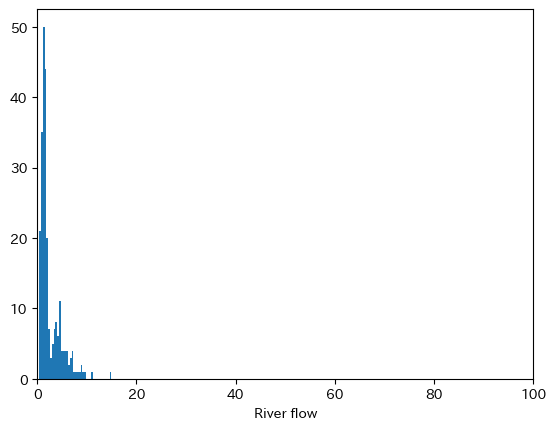

In [153]:
H = plt.hist(y, bins=40)
plt.xlim(0, 100)
plt.xlabel("River flow")

(0.0, 100.0)

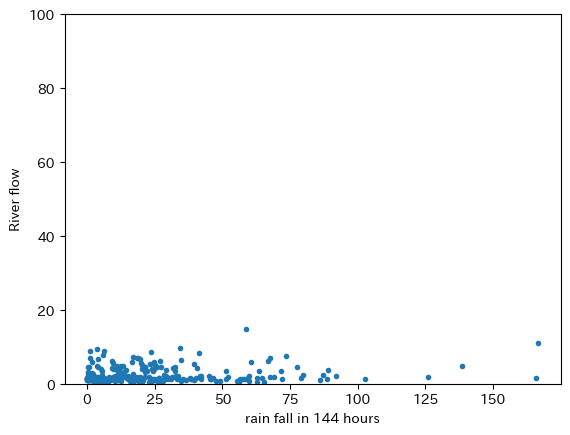

In [141]:
plt.plot(X.sum(axis=1), y, ".")
plt.xlabel("rain fall in 144 hours")
plt.ylabel("River flow")
plt.ylim(0, 100)

In [142]:
from sklearn import linear_model

reg_model = linear_model.LinearRegression()
reg_model.fit(X, y)

LinearRegression()

In [143]:
reg_model.intercept_

np.float64(2.0769229174985675)

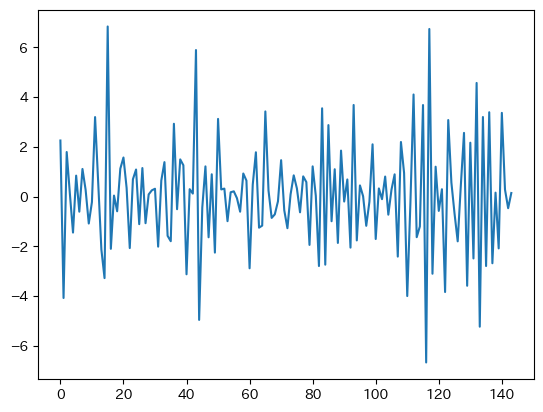

In [144]:
plt.plot(reg_model.coef_)

In [145]:
pred = reg_model.predict(X)

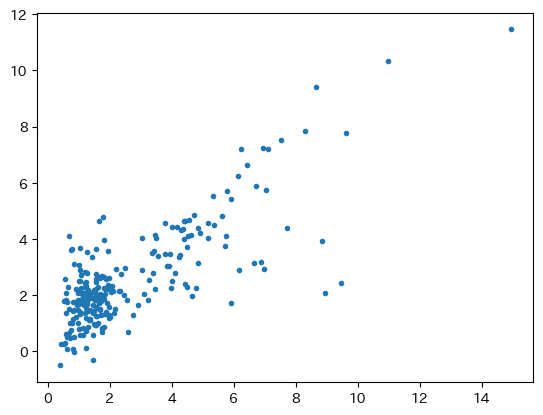

In [146]:
plt.plot(y, pred, ".")

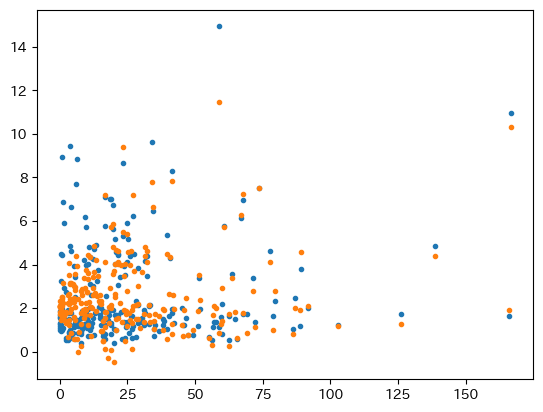

In [147]:
plt.plot(X.sum(axis=1), y, ".")
plt.plot(X.sum(axis=1), pred, ".")

極端に流量が多い日のデータにひっぱられるので、流量が200を越える日を排除してみる。

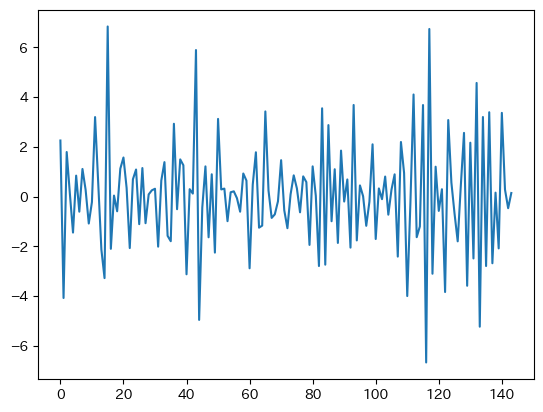

In [148]:
Xn = X[y < 20]
yn = y[y < 20]

reg_model = linear_model.LinearRegression()
reg_model.fit(Xn, yn)
plt.plot(reg_model.coef_)
predn = reg_model.predict(Xn)

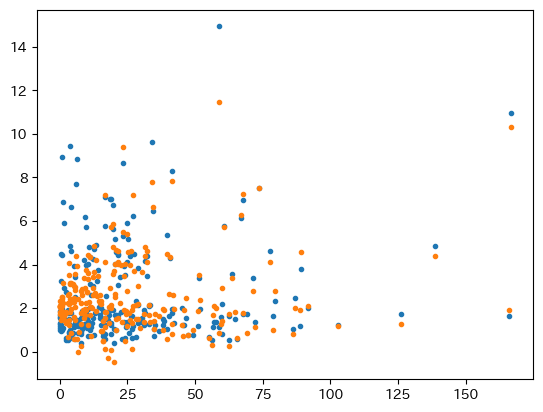

In [149]:
plt.plot(Xn.sum(axis=1), yn, ".")
plt.plot(Xn.sum(axis=1), predn, ".")

あきらかに過学習。144点のインパルス応答はフィットしきれない。

n時間の積算降水量からインパルス応答にしてみよう。

In [150]:
average_hours = 8  # hours
Xa = X.reshape(-1, 144 // average_hours, average_hours).sum(axis=2)
Xtick = [average_hours // 2 + x for x in range(0, 144, average_hours)]
Xa.shape

(252, 18)

2.2738242830608337


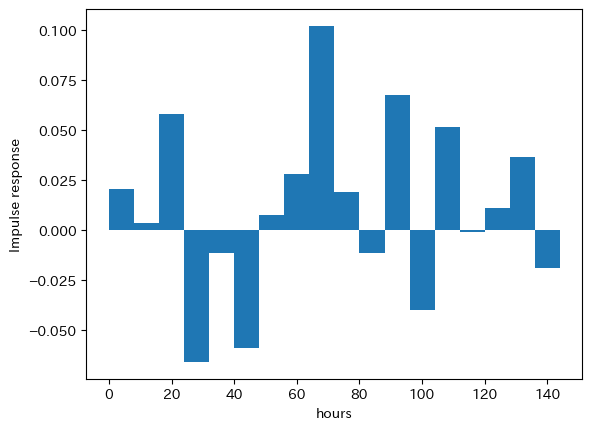

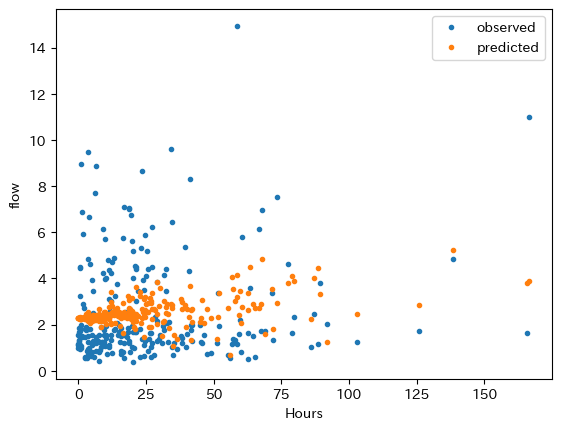

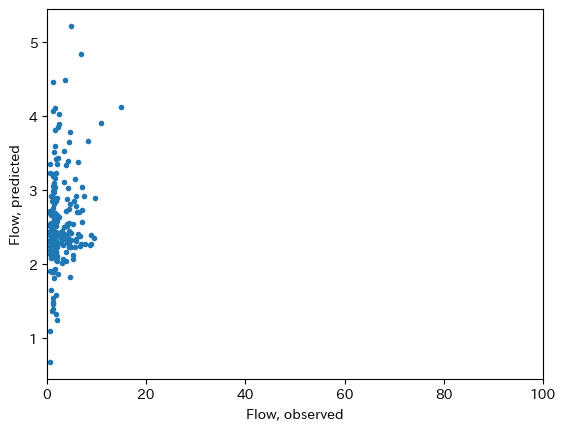

In [151]:
reg_model = linear_model.LinearRegression()
reg_model.fit(Xa, y)
plt.bar(Xtick, reg_model.coef_, width=average_hours)
print(reg_model.intercept_)
plt.xlabel("hours")
plt.ylabel("Impulse response")
plt.show()

preda = reg_model.predict(Xa)
plt.plot(Xa.sum(axis=1), y, ".", label="observed")
plt.plot(Xa.sum(axis=1), preda, ".", label="predicted")
plt.xlabel("Hours")
plt.ylabel("flow")
plt.legend()
plt.show()

plt.plot(y, preda, ".")
plt.xlim(0, 100)
plt.xlabel("Flow, observed")
plt.ylabel("Flow, predicted")
plt.show()

1. インパルス応答はそれらしい形が得られた。
    1. 桂川橋では、降雨から15時間ほどで水が急増する。すぐに来ないところが下流らしい。
    2. 負の係数は物理的にはおかしい。桂川では切片の値がかなり大きい(雨量0でも定常的に流れる流量が多い)ので、この程度の負の値はノイズとみなせるだろう。
2. 相関プロットはだめ。

全河川で比較してみよう。

(252, 288) (252,)
昭和橋 2.0322803752138023
(254, 288) (254,)
大月橋 3.9054143222868505
(252, 288) (252,)
桂川橋 29.089630284456327
(252, 288) (252,)
富士見橋 3.9827876124229915
(256, 288) (256,)
鶴川橋 0.8353509582298875
(252, 288) (252,)
西方寺橋 0.9860855268749118
(255, 288) (255,)
落合橋 0.15653121435185624
(253, 288) (253,)
流川 2.0081606106392176
(252, 288) (252,)
道志川 2.868810252916749
(252, 288) (252,)
秋山川 0.6531952038343611


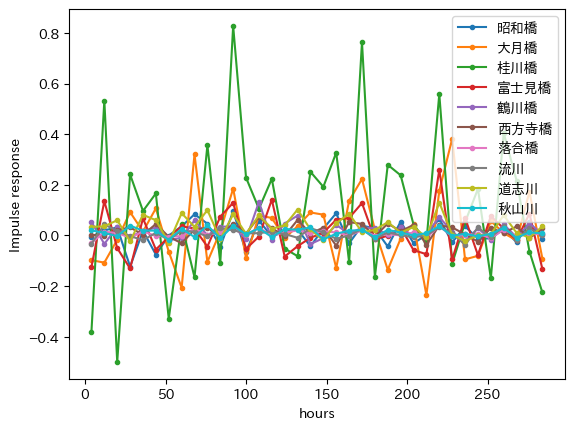

In [194]:
bridges = [
    "昭和橋",
    "大月橋",
    "桂川橋",
    "富士見橋",
    "鶴川橋",
    "西方寺橋",
    "落合橋",
    "流川",
    "道志川",
    "秋山川",
]

lookback = 24 * 12
average_hours = 8  # hours

tick, rains = delayed_data(大月, lookback=lookback)
# 最初が最新になるように反転(インパルス応答の目盛りにあわせる)
rains = rains[:, ::-1]
tick.head(), rains[:5]

for bridge in bridges:
    橋 = pd.read_csv(f"{bridge}.flow.csv", dtype={0: str, 1: str}, parse_dates=[1])
    # 分を0にした、切りのよい時刻を準備
    橋["time"] = 橋.datetime.dt.floor("h")
    X = []
    y = []
    for i, t in enumerate(橋.time):
        rows = tick == t
        row = rains[rows]
        if row.shape[0] == 1:
            X.append(row)
            y.append(橋[橋.time == t]["value"].to_numpy())

    X = np.array(X).reshape(-1, lookback)
    y = np.array(y).flatten()
    print(X.shape, y.shape)

    # 144時間分の過去データをaverage_hoursごとにきりわけて合計(積算)にする。
    Xa = X.reshape(-1, lookback // average_hours, average_hours).sum(axis=2)
    # プロット用の横軸。average_hours間隔で144時間分。
    Xtick = [average_hours // 2 + x for x in range(0, lookback, average_hours)]

    reg_model = linear_model.LinearRegression()
    reg_model.fit(Xa, y)
    # 線形回帰の係数=インパルス応答をプロット
    plt.plot(Xtick, reg_model.coef_, ".-", label=bridge)
    # plt.bar(Xtick, reg_model.coef_, width=average_hours, label=bridge)

    # 切片=定常流量。 どの川も非常に少ない。
    print(bridge, reg_model.intercept_)

plt.xlabel("hours")
plt.ylabel("Impulse response")
plt.legend()
plt.show()

インパルス応答に何の特徴もない。降水量と水量に何の関係もないことを暗示しているが、本当か?

(np.float64(12418.0), np.float64(12783.0))

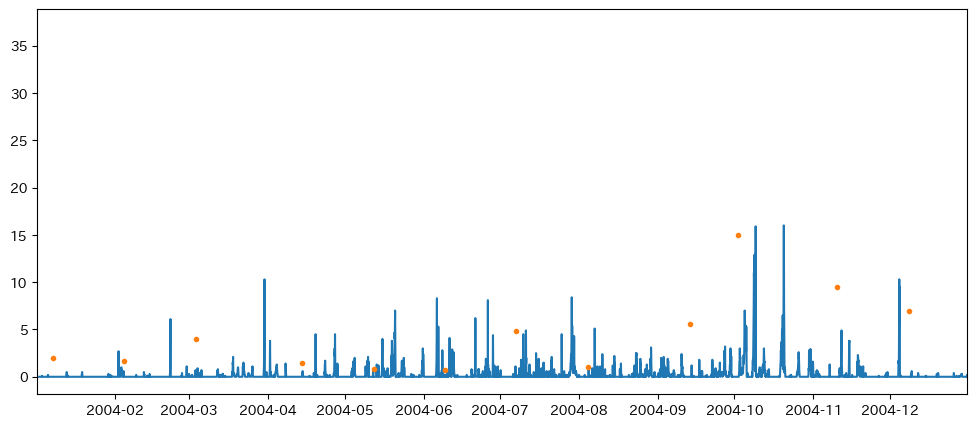

In [197]:
from datetime import date

# bridge = "昭和橋"
bridge = "昭和橋"
橋 = pd.read_csv(f"{bridge}.flow.csv", dtype={0: str, 1: str}, parse_dates=[1])
plt.figure(figsize=(12, 5))
plt.plot(大月.time, 大月["rain (mm)"])
# plt.plot(吉田.time, 吉田["rain (mm)"])
plt.plot(橋.datetime, 橋.value, ".")
plt.xlim(date(2004, 1, 1), date(2004, 12, 31))

雨量(青)と流量(オレンジ)の同時プロット。これを見ても、なぜ流量が増減するのかさっぱりわからない。

In [157]:
橋

,unixtime,datetime,value
0,956109900,2000-04-19 11:05:00+09:00,1.0200
1,957924300,2000-05-10 11:05:00+09:00,0.9700
2,960343500,2000-06-07 11:05:00+09:00,0.5700
3,962762460,2000-07-05 11:01:00+09:00,1.3400
4,965181840,2000-08-02 11:04:00+09:00,5.1800
...,...,...,...
259,1635990600,2021-11-04 10:50:00+09:00,3.0170
260,1638410700,2021-12-02 11:05:00+09:00,1.5534
261,1641433800,2022-01-06 10:50:00+09:00,1.8149
262,1643853300,2022-02-03 10:55:00+09:00,1.0389


In [209]:
大月JMA2000 = pd.read_csv("../大月open-meteo&気象庁.csv", header=None, parse_dates=[0])
# カラム名 (未確認)
大月JMA2000.columns = ["time", "OM", "rain (mm)"]
# Time zoneを設定しておく。1時間ずらす。
大月JMA2000.time = 大月JMA2000.iloc[:, 0].dt.tz_localize("Asia/Tokyo") + pd.DateOffset(
    hours=1
)
# OMのカラムはTZ不明なので消したほうがいいかも

大月JMA2000

,time,OM,rain (mm)
0,2000-04-01 01:00:00+09:00,0.0,0.0
1,2000-04-01 02:00:00+09:00,0.0,0.0
2,2000-04-01 03:00:00+09:00,0.0,0.0
3,2000-04-01 04:00:00+09:00,0.0,0.0
4,2000-04-01 05:00:00+09:00,0.0,0.0
...,...,...,...
8755,2001-03-31 20:00:00+09:00,0.0,0.0
8756,2001-03-31 21:00:00+09:00,0.0,0.0
8757,2001-03-31 22:00:00+09:00,0.0,0.0
8758,2001-03-31 23:00:00+09:00,0.0,0.0


In [233]:
大月JMA = []
for year in range(2000, 2024):
    print(year)
    df = pd.read_csv(
        f"../気象庁雨量（大月）/{year}.csv",
        skiprows=3,
        header=1,
        parse_dates=[0],
        encoding="Shift-JIS",
    )
    大月JMA.append(df)

大月JMA = pd.concat(大月JMA, axis=0)
# カラム名 (未確認)
大月JMA.columns = ["time", "rain (mm)", "品質情報", "均質番号"]
# Time zoneを設定しておく。1時間ずらす。
大月JMA.time = 大月JMA.iloc[:, 0].dt.tz_localize("Asia/Tokyo")
# OMのカラムはTZ不明なので消したほうがいいかも

大月JMA.head()

2000
2001
2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020
2021
2022
2023


,time,rain (mm),品質情報,均質番号
0,2000-04-01 01:00:00+09:00,0.0,8,1
1,2000-04-01 02:00:00+09:00,0.0,8,1
2,2000-04-01 03:00:00+09:00,0.0,8,1
3,2000-04-01 04:00:00+09:00,0.0,8,1
4,2000-04-01 05:00:00+09:00,0.0,8,1


昭和橋 2.530162869458303
大月橋 5.320254535797556
桂川橋 35.81043786186464
富士見橋 4.7132674263916945
鶴川橋 1.8248405024566474
西方寺橋 1.9255819308433226
落合橋 0.5437521056991911
流川 2.3138947158775176
道志川 4.560111842608623
秋山川 1.2140656355936552


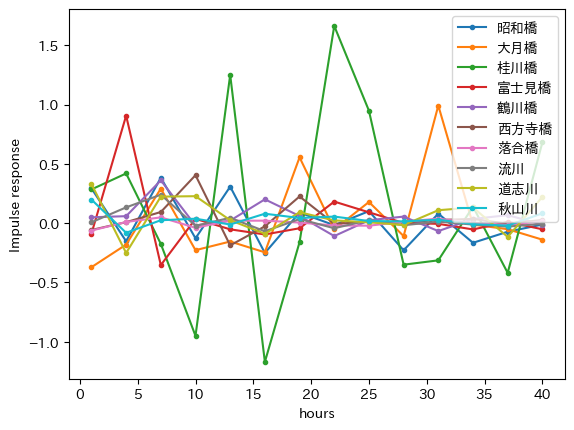

In [245]:
bridges = [
    "昭和橋",
    "大月橋",
    "桂川橋",
    "富士見橋",
    "鶴川橋",
    "西方寺橋",
    "落合橋",
    "流川",
    "道志川",
    "秋山川",
]


lookback = 6 * 7  # 24 * 12
average_hours = 3  # hours

tick, rains = delayed_data(大月JMA, lookback=lookback)
# 最初が最新になるように反転(インパルス応答の目盛りにあわせる)
rains = rains[:, ::-1]
tick.head(), rains[:5]

for bridge in bridges:
    橋 = pd.read_csv(f"{bridge}.flow.csv", dtype={0: str, 1: str}, parse_dates=[1])
    # 分を0にした、切りのよい時刻を準備
    橋["time"] = 橋.datetime.dt.floor("h")
    X = []
    y = []
    for i, t in enumerate(橋.time):
        rows = tick == t
        row = rains[rows]
        if row.shape[0] == 1:
            X.append(row)
            y.append(橋[橋.time == t]["value"].to_numpy())

    X = np.array(X).reshape(-1, lookback)
    y = np.array(y).flatten()
    nan_rows = np.isnan(X).any(axis=1)
    X = X[~nan_rows]
    y = y[~nan_rows]

    # 144時間分の過去データをaverage_hoursごとにきりわけて合計(積算)にする。
    Xa = X.reshape(-1, lookback // average_hours, average_hours).sum(axis=2)
    # プロット用の横軸。average_hours間隔で144時間分。
    Xtick = [average_hours // 2 + x for x in range(0, lookback, average_hours)]

    reg_model = linear_model.LinearRegression()
    reg_model.fit(Xa, y)
    # 線形回帰の係数=インパルス応答をプロット
    plt.plot(Xtick, reg_model.coef_, ".-", label=bridge)
    # plt.bar(Xtick, reg_model.coef_, width=average_hours, label=bridge)

    # 切片=定常流量。 どの川も非常に少ない。
    print(bridge, reg_model.intercept_)

plt.xlabel("hours")
plt.ylabel("Impulse response")
plt.legend()
plt.show()

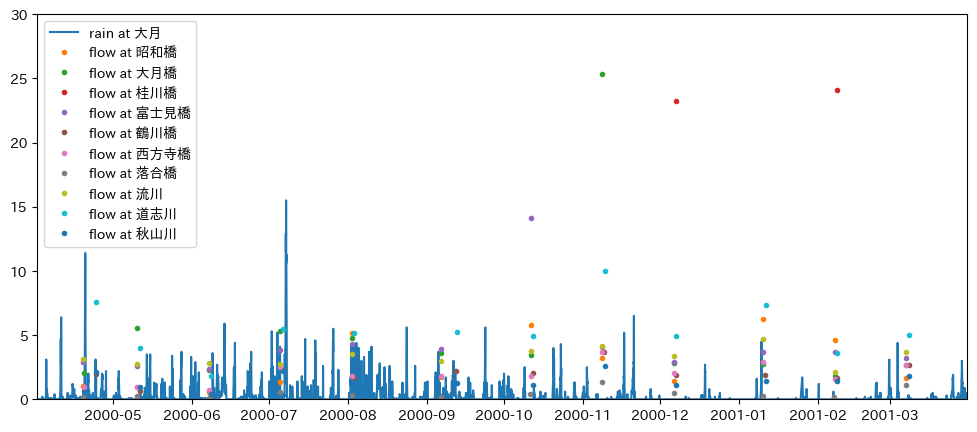

In [219]:
from datetime import date

bridges = [
    "昭和橋",
    "大月橋",
    "桂川橋",
    "富士見橋",
    "鶴川橋",
    "西方寺橋",
    "落合橋",
    "流川",
    "道志川",
    "秋山川",
]

plt.figure(figsize=(12, 5))
plt.plot(大月JMA2000.time, 大月JMA2000["rain (mm)"], label=f"rain at 大月")

for bridge in bridges:
    橋 = pd.read_csv(f"{bridge}.flow.csv", dtype={0: str, 1: str}, parse_dates=[1])
    # plt.plot(吉田.time, 吉田["rain (mm)"])
    plt.plot(橋.datetime, 橋.value, ".", label=f"flow at {bridge}")

plt.xlim(date(2000, 4, 1), date(2001, 3, 31))
plt.ylim(0, 30)
plt.legend()

(12, 24) (12,)
昭和橋 [[1.         0.67531082]
 [0.67531082 1.        ]]


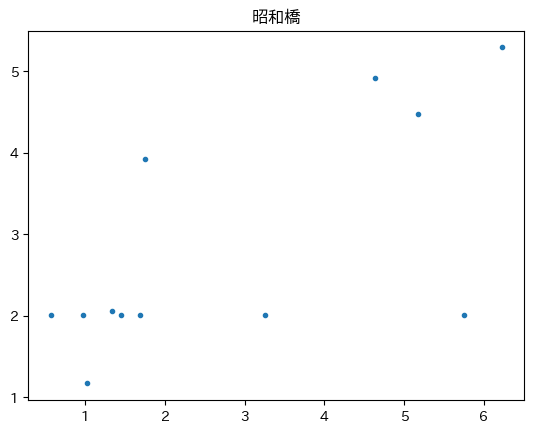

(12, 24) (12,)
大月橋 [[1.         0.22318697]
 [0.22318697 1.        ]]


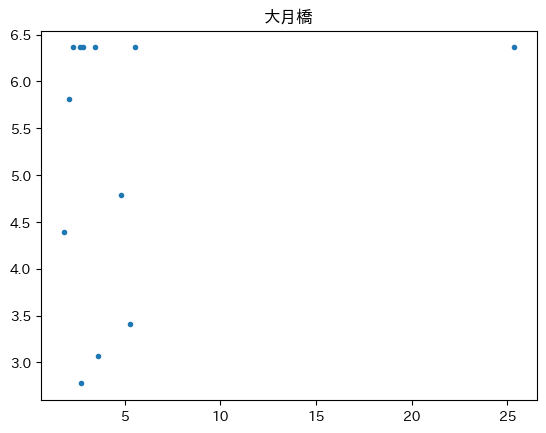

(12, 24) (12,)
桂川橋 [[1.         0.68075929]
 [0.68075929 1.        ]]


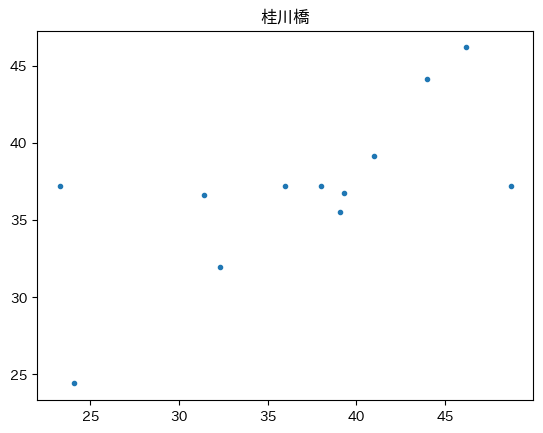

(12, 24) (12,)
富士見橋 [[1.         0.10904076]
 [0.10904076 1.        ]]


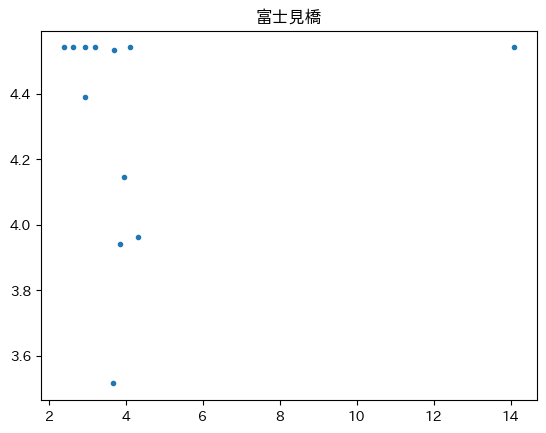

(12, 24) (12,)
鶴川橋 [[1.         0.16692086]
 [0.16692086 1.        ]]


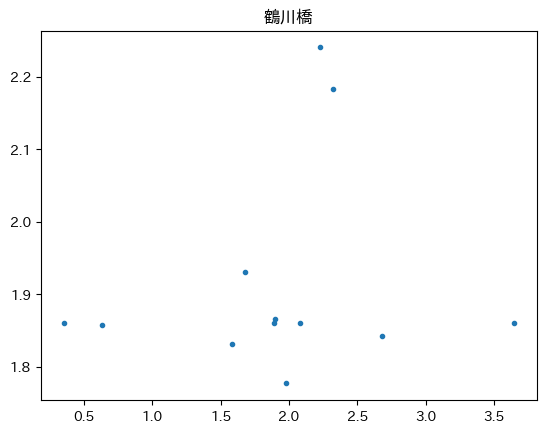

(12, 24) (12,)
西方寺橋 [[1.        0.3417007]
 [0.3417007 1.       ]]


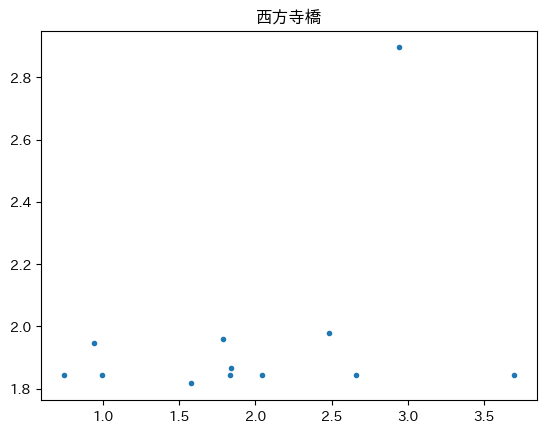

(12, 24) (12,)
落合橋 [[1.         0.36193489]
 [0.36193489 1.        ]]


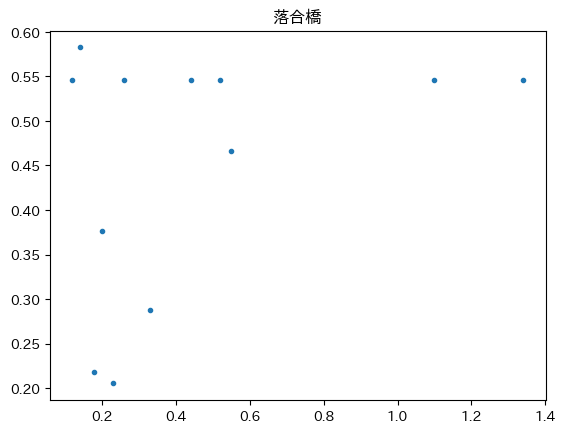

(12, 24) (12,)
流川 [[1.         0.61579074]
 [0.61579074 1.        ]]


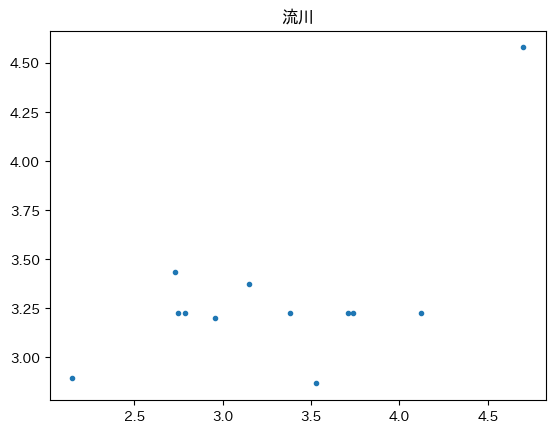

(12, 24) (12,)
道志川 [[1.        0.3898259]
 [0.3898259 1.       ]]


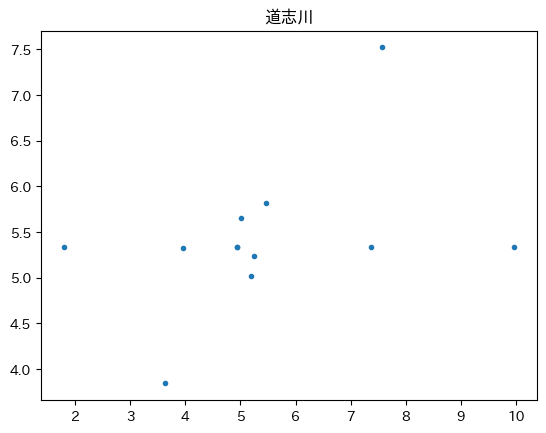

(12, 24) (12,)
秋山川 [[1.         0.45860377]
 [0.45860377 1.        ]]


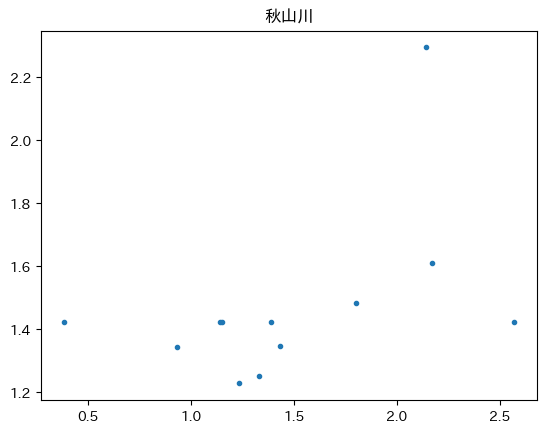

In [228]:
bridges = [
    "昭和橋",
    "大月橋",
    "桂川橋",
    "富士見橋",
    "鶴川橋",
    "西方寺橋",
    "落合橋",
    "流川",
    "道志川",
    "秋山川",
]


lookback = 6 * 4  # 24 * 12
average_hours = 6  # hours

tick, rains = delayed_data(大月JMA2000, lookback=lookback)
# 最初が最新になるように反転(インパルス応答の目盛りにあわせる)
rains = rains[:, ::-1]
tick.head(), rains[:5]

for bridge in bridges:
    橋 = pd.read_csv(f"{bridge}.flow.csv", dtype={0: str, 1: str}, parse_dates=[1])
    # 分を0にした、切りのよい時刻を準備
    橋["time"] = 橋.datetime.dt.floor("h")
    X = []
    y = []
    for i, t in enumerate(橋.time):
        rows = tick == t
        row = rains[rows]
        if row.shape[0] == 1:
            X.append(row)
            y.append(橋[橋.time == t]["value"].to_numpy())

    X = np.array(X).reshape(-1, lookback)
    y = np.array(y).flatten()
    print(X.shape, y.shape)

    # 144時間分の過去データをaverage_hoursごとにきりわけて合計(積算)にする。
    Xa = X.reshape(-1, lookback // average_hours, average_hours).sum(axis=2)
    # プロット用の横軸。average_hours間隔で144時間分。
    Xtick = [average_hours // 2 + x for x in range(0, lookback, average_hours)]

    reg_model = linear_model.LinearRegression()
    reg_model.fit(Xa, y)

    preda = reg_model.predict(Xa)
    print(f"{bridge} {np.corrcoef(preda, y)}")

    plt.plot(y, preda, ".", label=bridge)
    plt.title(bridge)
    plt.show()
    # plt.legend()